# Deep Learning HW2: Classification using Convolutional Neural Networks

## Part 2: (Weather Classification)

#### Import Libraries

In [152]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from google.colab import drive
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import shutil
from PIL import Image
import random
import torch.nn as nn
import numpy as np
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Connect to Google Drive

In [153]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Preprocess Data: Extract Training and Test Datasets

This cell extracts the training and test datasets from zip files, removes unnecessary __MACOSX directories to clean the dataset, organize the Test folder and create subdirectories based on the naming convention of the test images.

In [154]:
# Path to the dataset
dataset_path = '/content/drive/MyDrive/DataSet/'
train_path = os.path.join(dataset_path, 'Train')
test_path = os.path.join(dataset_path, 'Test')

# Paths for extracted folders
train_extract_path = os.path.join(dataset_path, 'Extracted_Train')
test_extract_path = os.path.join(dataset_path, 'Extracted_Test')

# Create folders for extracted data
os.makedirs(train_extract_path, exist_ok=True)
os.makedirs(test_extract_path, exist_ok=True)

# Extract train zip files
for file_name in os.listdir(train_path):
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(train_path, file_name), 'r') as zip_ref:
            zip_ref.extractall(os.path.join(train_extract_path, file_name.split('.')[0]))
            print(f"Extracted {file_name} to {train_extract_path}")

# Extract test zip file
for file_name in os.listdir(test_path):
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(test_path, file_name), 'r') as zip_ref:
            zip_ref.extractall(test_extract_path)
            print(f"Extracted {file_name} to {test_extract_path}")

# remove all __MACOSX directories
def remove_macosx_dirs(base_path):
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            if dir_name == "__MACOSX":
                dir_path = os.path.join(root, dir_name)
                shutil.rmtree(dir_path)
                print(f"Removed: {dir_path}")

# Remove __MACOSX directories from both extracted train and test folders
remove_macosx_dirs(train_extract_path)
remove_macosx_dirs(test_extract_path)


test_dir = '/content/drive/MyDrive/DataSet/Extracted_Test/Test'
class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

# Create subdirectories for each class
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

for file_name in os.listdir(test_dir):
    if file_name.endswith('.jpg'):  # Ensure it's an image file
        for class_name in class_names:
            if file_name.lower().startswith(class_name.lower()):
                source_path = os.path.join(test_dir, file_name)
                destination_path = os.path.join(test_dir, class_name, file_name)
                shutil.move(source_path, destination_path)

Extracted Shine.zip to /content/drive/MyDrive/DataSet/Extracted_Train
Extracted Cloudy.zip to /content/drive/MyDrive/DataSet/Extracted_Train
Extracted Rain.zip to /content/drive/MyDrive/DataSet/Extracted_Train
Extracted Sunrise.zip to /content/drive/MyDrive/DataSet/Extracted_Train
Extracted Test.zip to /content/drive/MyDrive/DataSet/Extracted_Test
Removed: /content/drive/MyDrive/DataSet/Extracted_Train/Shine/__MACOSX
Removed: /content/drive/MyDrive/DataSet/Extracted_Train/Cloudy/__MACOSX
Removed: /content/drive/MyDrive/DataSet/Extracted_Train/Rain/__MACOSX
Removed: /content/drive/MyDrive/DataSet/Extracted_Train/Sunrise/__MACOSX
Removed: /content/drive/MyDrive/DataSet/Extracted_Test/__MACOSX


####  Load and Preprocess Dataset

In this part, we will load the extracted training and testing datasets into PyTorch-compatible data loaders. We will apply data preprocessing steps such as resizing the images, normalization, and creating batches to prepare the data for model training.

In [155]:
# Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load the datasets
train_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/DataSet/Extracted_Train", transform=train_transforms)
test_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/DataSet/Extracted_Test/Test", transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Number of training samples: 1065
Number of testing samples: 60
Classes: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


####  Showcase Sample Images from Each Class

We selects two random images from each class (Cloudy, Rain, Shine, Sunrise) and organizes them into a single figure with 2 rows and 4 columns. Each column represents a specific class, and the images are labeled with their corresponding class name.

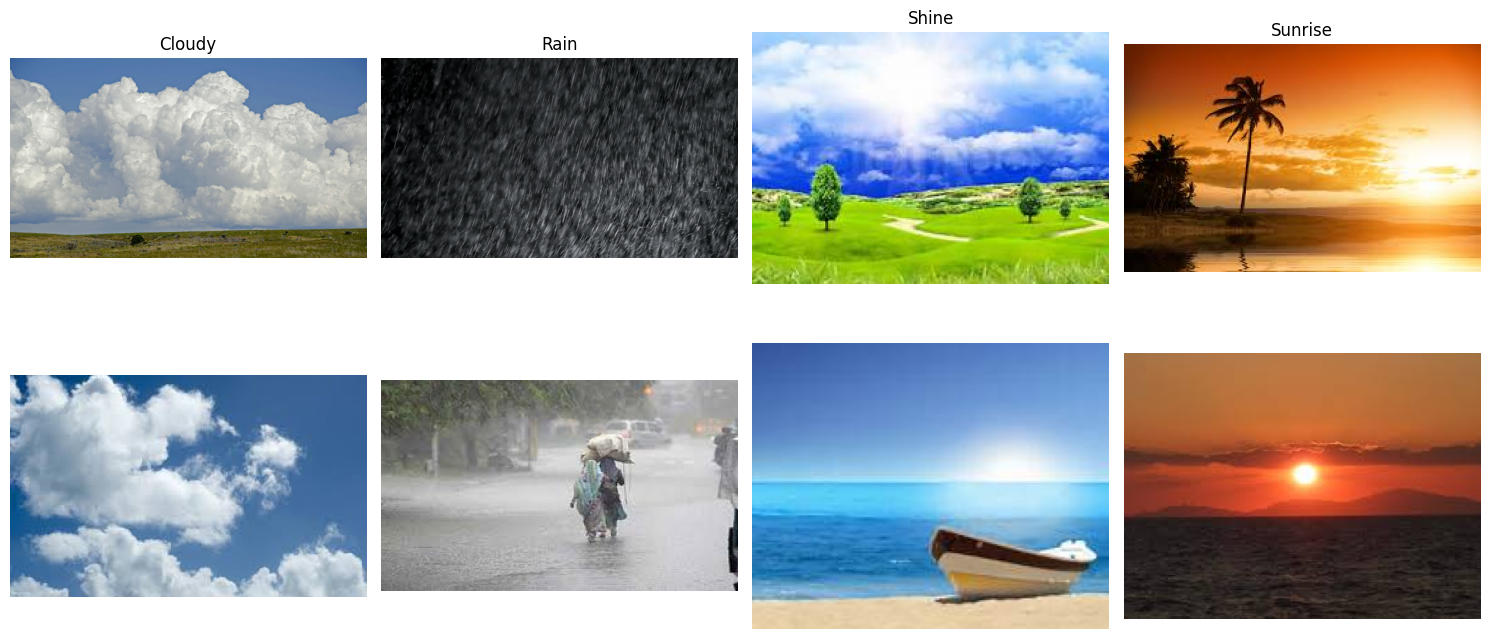

In [156]:
train_dir = "/content/drive/MyDrive/DataSet/Extracted_Train"
classes = ["Cloudy", "Rain", "Shine", "Sunrise"]

# Prepare a figure for displaying images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for col, cls in enumerate(classes):
    class_dir = os.path.join(train_dir, cls)
    class_dir = os.path.join(class_dir, cls)
    images = os.listdir(class_dir)

    # Select two random images for each class
    selected_images = random.sample(images, 2)

    for row, img_name in enumerate(selected_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        if row == 0:
            axes[row, col].set_title(cls)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


####  Load a Pretrained Model and Adapt for Weather Classification

This cell loads a pretrained ResNet50 model from PyTorch and modifies its final fully connected layer to classify the 4 weather conditions. ResNet50 is chosen due to its effectiveness in image classification tasks and ability to leverage pretrained weights for improved accuracy and faster convergence.

In [157]:
# Load the pretrained ResNet50 model
pretrained_model = models.resnet50(pretrained=True)

# Freeze the feature extraction layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for 4 classes
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_model = pretrained_model.to(device)

print("Model Architecture:")
print(pretrained_model)

total_params = sum(p.numel() for p in pretrained_model.parameters())
trainable_params = sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")

Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

#### Mathematical Representation of the Loss Function

 We first represent our custom loss function mathematically:

$$
\text{Cross-Entropy Loss:} \quad \text{CE}(\hat{y}, y) = -\frac{1}{N} \sum_{i=1}^N y_i \cdot \log(\hat{y}_i + \epsilon)
$$

$$
\text{Regularization Term:} \quad \text{Reg}(\theta) = \frac{\lambda}{2} \sum_{j=1}^M \|\theta_j\|^2
$$

$$
\text{Custom Loss Function:} \quad \mathcal{L}(\hat{y}, y; \theta) = \alpha \cdot \text{CE}(\hat{y}, y) + \text{Reg}(\theta)
$$






####  Implementation of the Custom Loss Function

 we will implement the custom loss function as described earlier:

In [158]:
class MyLossFunction(nn.Module):
    def __init__(self, alpha=1.0, lambda_=0.01, epsilon=1e-8, class_weights=None):
        super(MyLossFunction, self).__init__()
        self.alpha = alpha
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.class_weights = class_weights

    def forward(self, predictions, targets, model):
        batch_size = predictions.size(0)

        # Cross-Entropy Loss
        if self.class_weights is not None:
            ce_loss = -torch.sum(self.class_weights[targets] * torch.log(predictions + self.epsilon)) / batch_size
        else:
            ce_loss = -torch.sum(targets * torch.log(predictions + self.epsilon)) / batch_size

        # L2 Regularization Term
        l2_reg = 0.0
        for param in model.parameters():
            if param.requires_grad:
                l2_reg += torch.sum(param.pow(2))
        l2_reg = (self.lambda_ / 2) * l2_reg

        # Combine the two terms
        total_loss = self.alpha * ce_loss + l2_reg
        return total_loss

#### Split the Dataset and create Data Loaders

In [159]:
val_split_ratio = 0.2  # 20% for validation
train_size = int((1 - val_split_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train_dataset into train and validation sets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for the subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Confirm sizes of the datasets
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")

Training set size: 852
Validation set size: 213


#### Training and Validation

In this step, we fine-tune the pretrained ResNet50 model using the custom MyLossFunction. The model is trained on the training dataset (train_loader) and validated on the validation dataset (val_loader)


In [160]:
def calculate_accuracy(predictions, targets):
    _, predicted_classes = torch.max(predictions, 1)
    _, true_classes = torch.max(targets, 1)
    correct = (predicted_classes == true_classes).sum().item()
    return correct / targets.size(0)

def train_and_validate(
    model, train_loader, val_loader, loss_function, optimizer, device, epochs=10
):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        running_train_acc = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # One-hot encode the targets
            targets_onehot = F.one_hot(targets, num_classes=4).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(F.softmax(outputs, dim=1), targets_onehot, model)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            running_train_acc += calculate_accuracy(F.softmax(outputs, dim=1), targets_onehot)


        # Calculate average training loss and accuracy
        train_loss = running_train_loss / len(train_loader)
        train_acc = 100 * running_train_acc / len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        running_val_loss = 0.0
        running_val_acc = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # One-hot encode the targets
                targets_onehot = F.one_hot(targets, num_classes=4).float()

                outputs = model(inputs)
                loss = loss_function(F.softmax(outputs, dim=1), targets_onehot, model)

                running_val_loss += loss.item()
                running_val_acc += calculate_accuracy(F.softmax(outputs, dim=1), targets_onehot)

        # Calculate average validation loss and accuracy
        val_loss = running_val_loss / len(val_loader)
        val_acc = 100 * running_val_acc / len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model=pretrained_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=MyLossFunction(alpha=1.0, lambda_=0.05),
    optimizer=optimizer,
    device=device,
    epochs=10
)

Epoch 1/10, Train Loss: 1.0279, Train Accuracy: 63.06%, Val Loss: 0.5690, Val Accuracy: 85.25%
Epoch 2/10, Train Loss: 0.4536, Train Accuracy: 91.69%, Val Loss: 0.3166, Val Accuracy: 97.30%
Epoch 3/10, Train Loss: 0.3379, Train Accuracy: 94.26%, Val Loss: 0.2756, Val Accuracy: 97.30%
Epoch 4/10, Train Loss: 0.2833, Train Accuracy: 95.25%, Val Loss: 0.2471, Val Accuracy: 97.09%
Epoch 5/10, Train Loss: 0.2811, Train Accuracy: 94.49%, Val Loss: 0.2370, Val Accuracy: 97.09%
Epoch 6/10, Train Loss: 0.3087, Train Accuracy: 93.75%, Val Loss: 0.2612, Val Accuracy: 95.30%
Epoch 7/10, Train Loss: 0.2415, Train Accuracy: 96.57%, Val Loss: 0.2438, Val Accuracy: 95.07%
Epoch 8/10, Train Loss: 0.2520, Train Accuracy: 96.18%, Val Loss: 0.2144, Val Accuracy: 96.85%
Epoch 9/10, Train Loss: 0.2353, Train Accuracy: 96.57%, Val Loss: 0.2178, Val Accuracy: 96.64%
Epoch 10/10, Train Loss: 0.2099, Train Accuracy: 98.03%, Val Loss: 0.2274, Val Accuracy: 95.96%


#### Visualize Training and Validation Results

Here, we visualize the results by plotting the loss and accuracy over the epochs.

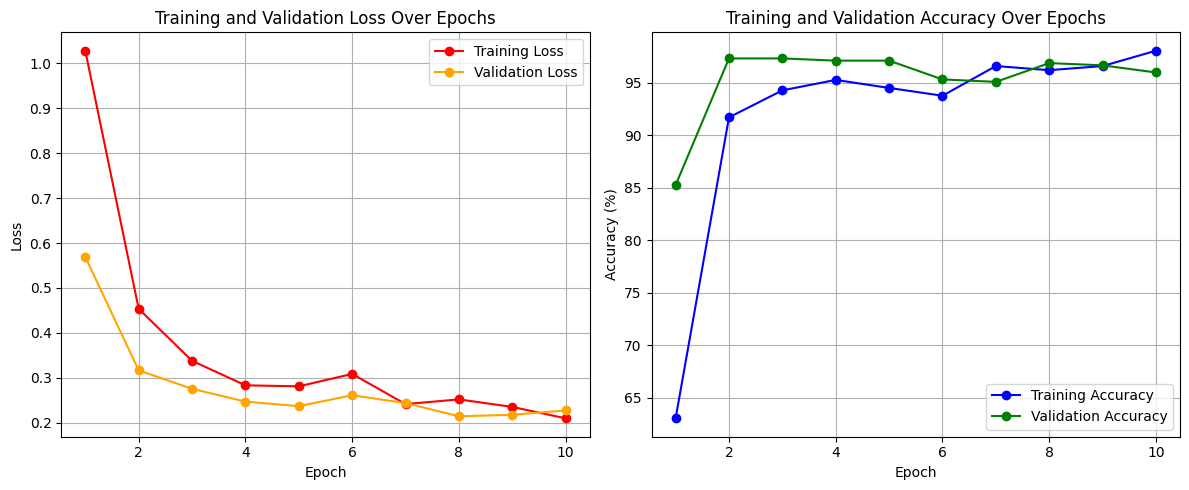

In [161]:
def visualize_training_validation_results(
    train_losses, train_accuracies, val_losses, val_accuracies, title_prefix="Training and Validation"
):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='red', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} Loss Over Epochs')
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title_prefix} Accuracy Over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_training_validation_results(train_losses, train_accuracies, val_losses, val_accuracies)


#### Evaluate the Model on the Test Dataset

After the training, we will evaluate the model performance on the test dataset.

In [162]:
def evaluate_model(model, testloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate the model on the test set
acc = evaluate_model(pretrained_model, test_loader)


Test Accuracy: 96.67%


#### Generating the Confusion Matrix

We implemnt this function to computes and displays a confusion matrix for the test set.

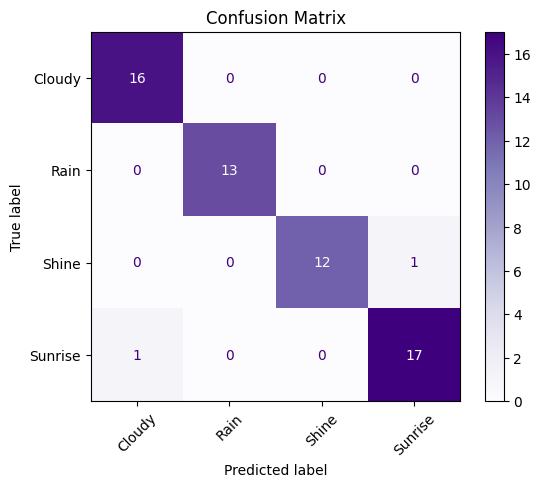

In [163]:
def show_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Get predictions
            outputs = model(inputs)
            _, predicted_classes = torch.max(F.softmax(outputs, dim=1), 1)

            # Collect targets and predictions
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted_classes.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_predictions, labels=range(len(class_names)))

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Purples', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

show_confusion_matrix(
    model=pretrained_model,
    test_loader=test_loader,
    device=device,
    class_names=class_names
)


#### Visualizing Random Test Predictions

This function displays 10 random images from the test dataset along with their orginal labels and predicted labels.


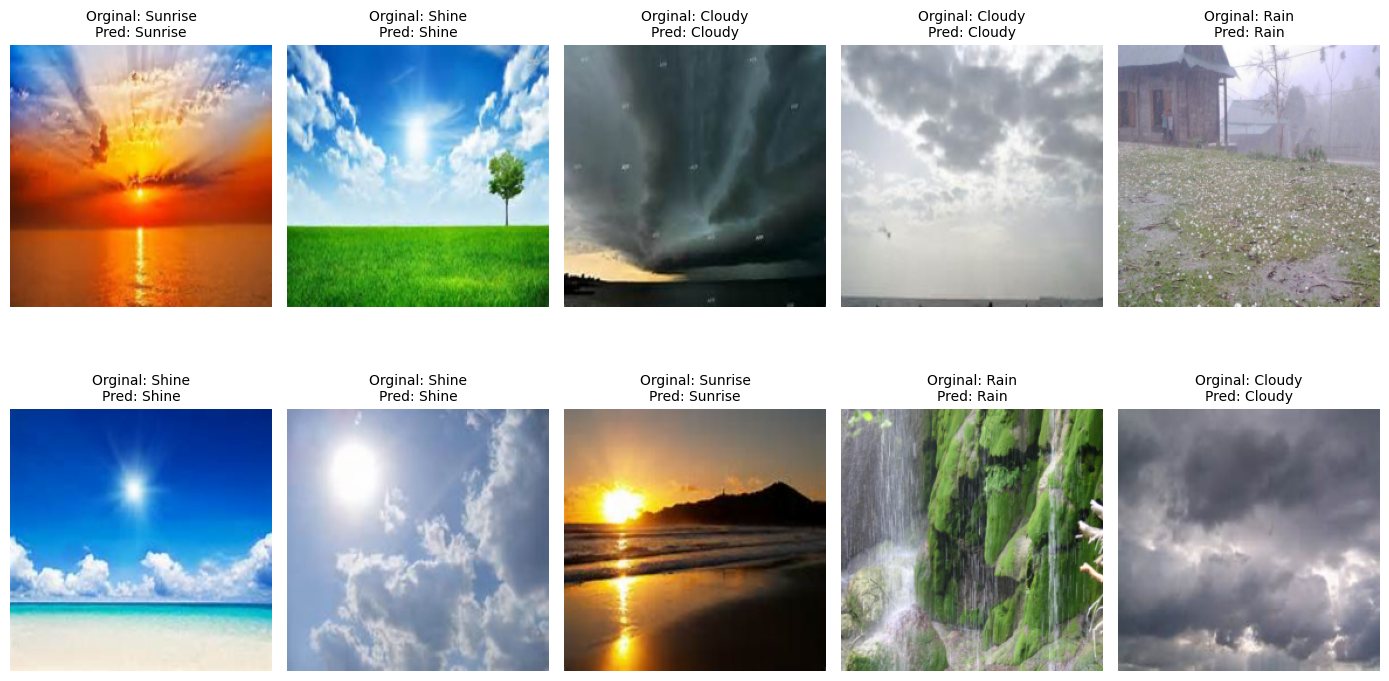

In [166]:
def show_predictions(model, dataset, device, class_names, num_images=6):
    model.eval()

    # Randomly select indices
    indices = random.sample(range(len(dataset)), num_images)
    images, true_labels, predicted_labels = [], [], []

    with torch.no_grad():
        for idx in indices:
            image, true_label = dataset[idx]
            images.append(image)
            true_labels.append(true_label)

            # Prepare the image for the model
            input_image = image.unsqueeze(0).to(device)
            outputs = model(input_image)
            _, predicted_class = torch.max(F.softmax(outputs, dim=1), 1)
            predicted_labels.append(predicted_class.cpu().item())

    fig, axes = plt.subplots(2, 5, figsize=(14, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].permute(1, 2, 0)
            img = img * 0.5 + 0.5  # Denormalize
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(
                f"Orginal: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}",
                fontsize=10,
            )
    plt.tight_layout()
    plt.show()


class_names = train_dataset.classes
show_predictions(
    model=pretrained_model,
    dataset=test_dataset,
    device=device,
    class_names=class_names,
    num_images=10
)

#### UMAP Visualization of Model Classification

We use UMAP to reduce the model’s high-dimensional feature space to a 2D plane, allowing us to visualize how well the model separates classes.

- Feature Extraction: Features are taken from the penultimate layer of the model for the test dataset.

- UMAP Reduction: These features are projected into 2D while preserving relationships between samples.

- Visualization: Points are plotted by class, with distinct clusters indicating the model's ability to distinguish between classes.

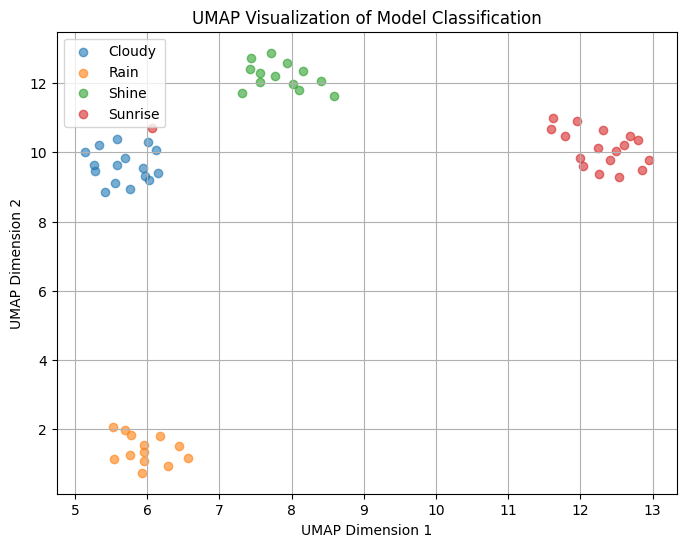

In [167]:
import umap.umap_ as umap
import warnings
warnings.filterwarnings("ignore")

# !pip install umap-learn

def visualize_with_umap(model, test_loader, device, class_names):

    model.eval()

    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Extract features from the model (before the final classification layer)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())

    # Combine all batches into single arrays
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply UMAP to reduce the dimensionality to 2D
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_features = umap_reducer.fit_transform(features)

    # Plot the 2D projection
    plt.figure(figsize=(8, 6))
    for class_index, class_name in enumerate(class_names):
        idx = labels == class_index
        plt.scatter(
            reduced_features[idx, 0],
            reduced_features[idx, 1],
            label=class_name,
            alpha=0.6
        )

    plt.title("UMAP Visualization of Model Classification")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_with_umap(
    model=pretrained_model,
    test_loader=test_loader,
    device=device,
    class_names=train_dataset.classes
)